# 연습문제

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 준비

In [3]:
origin = pd.read_excel('https://data.hossam.kr/F02/fish2.xlsx')
origin.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #03. 데이터 전처리

In [4]:
origin.isnull().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

### 상자그림
정규화 ㄱㄱ해야함

<Axes: >

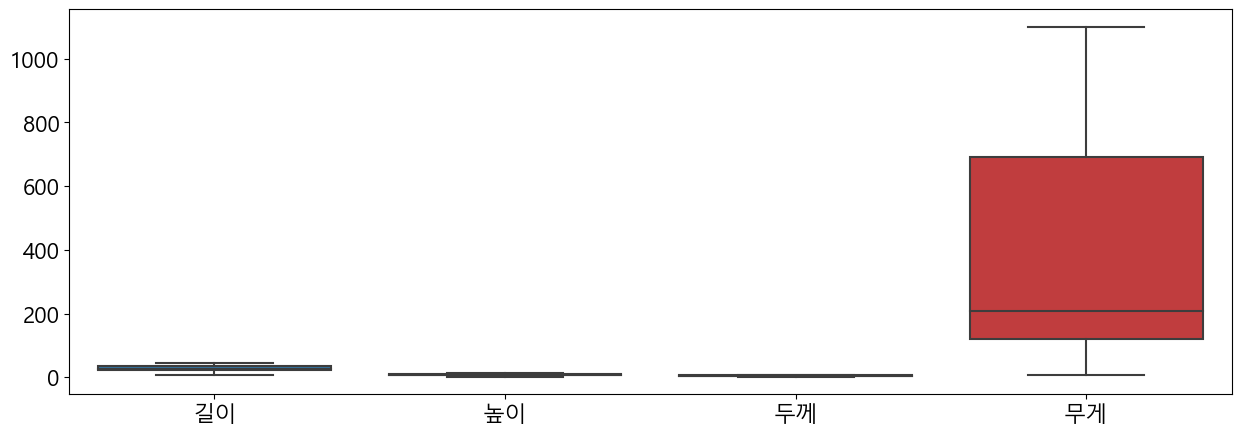

In [5]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15,5))
sns.boxplot(data=origin)

### 산점도 그래프와 추세선 확인
선형x -> 다항식 생성해야함



C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

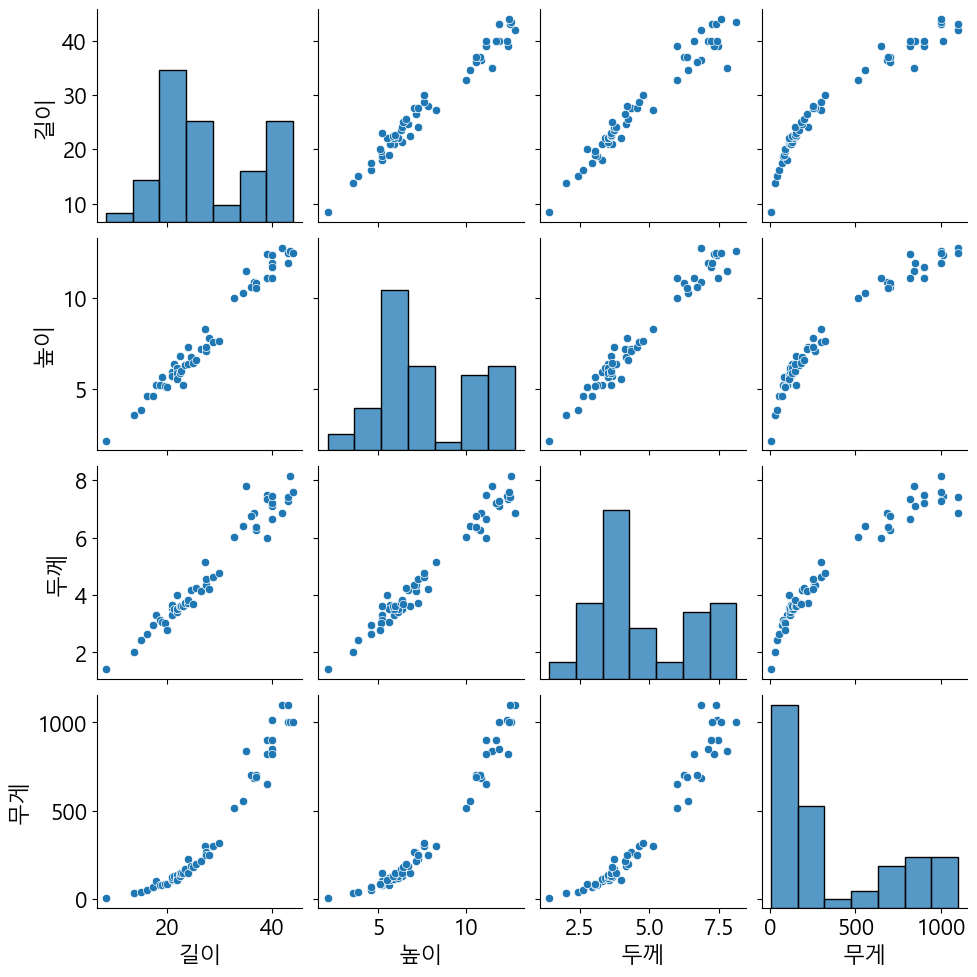

In [6]:


plt.figure(figsize=(20,20))
sns.pairplot(origin)


> 다중공선성이 발생할 것으로 보이고 선형회귀보다는 다항회귀가 적합해 보임(곡선형태기 떄문)

## #04. 다항식 생성

### 독립 - 종속변수 분할

In [7]:
x = origin[['길이','높이','두께']]
y= origin[['무게']]
print('독립변수 : ',x.shape,'종속변수 : ',y.shape)

독립변수 :  (56, 3) 종속변수 :  (56, 1)


In [8]:
poly = PolynomialFeatures(degree=2,include_bias=False)
x  = poly.fit_transform(x)


In [9]:
poly.get_feature_names_out()

array(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께',
       '두께^2'], dtype=object)

In [10]:
x = pd.DataFrame(x,columns=poly.get_feature_names_out())
x.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881
1,13.7,3.53,2.00,187.69,48.361,27.400,12.4609,7.0600,4.0000
2,15.0,3.82,2.43,225.00,57.300,36.450,14.5924,9.2826,5.9049
3,16.2,4.59,2.63,262.44,74.358,42.606,21.0681,12.0717,6.9169
4,17.4,4.59,2.94,302.76,79.866,51.156,21.0681,13.4946,8.6436


<Axes: >

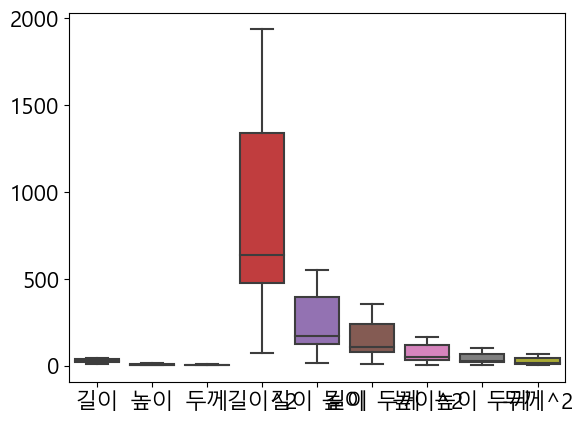

In [11]:
sns.boxplot(x)

## #05. 데이터 분할

### 랜덤시드 고정

In [12]:
np.random.seed(777)

In [13]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scale = x_scaler.fit_transform(x)
y_scale = y_scaler.fit_transform(y)

x_scale.shape,y_scale.shape


((56, 9), (56, 1))

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x_scale,y_scale,test_size=0.3,random_state=777)
print(len(y_train),len(x_test))


39 17


In [15]:
### 표준화 전 후 상자그림 비교 
x_scale_df = pd.DataFrame(x_scale,columns=x.columns)
y_scale_df = pd.DataFrame(y_scale,columns=['무게'])
tmp = pd.merge(x_scale_df,y_scale_df,left_index= True,right_index=True)
tmp.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,-1.092422
1,-1.587434,-1.518703,-1.560774,-1.275113,-1.235186,-1.243176,-1.192006,-1.196934,-1.189907,-1.016660
2,-1.442032,-1.417039,-1.316328,-1.204133,-1.178873,-1.149649,-1.147811,-1.121318,-1.085040,-0.993438
3,-1.307815,-1.147103,-1.202633,-1.132907,-1.071415,-1.086030,-1.013541,-1.026429,-1.029328,-0.960056
4,-1.173599,-1.147103,-1.026405,-1.056201,-1.036717,-0.997670,-1.013541,-0.978020,-0.934271,-0.906355


<Axes: >

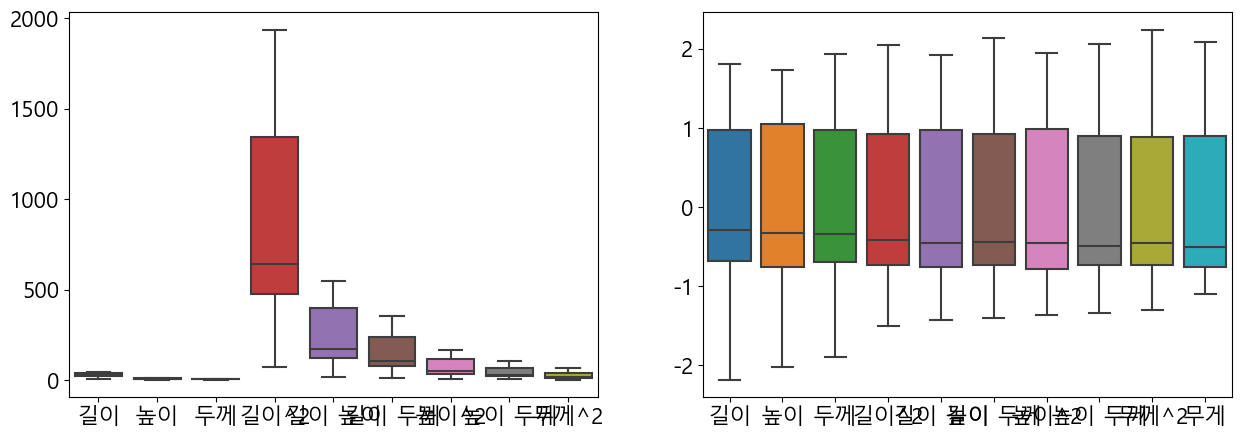

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=x,ax=ax[0])
sns.boxplot(data=tmp,ax=ax[1])

## #06.모델개발
### 1.모델 정의

In [17]:
len(x.columns)

9

In [18]:
model = Sequential()
model.add(Dense(18,activation = 'relu',input_shape=(9,)))
model.add(Dense(9,activation = 'relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics = ['mae'])
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000001DBC5FC2A30>>

### 2. 학습하기

In [19]:
checkpoint_path = os.path.join("D:\\tensorflow_checkpoint\\model07-cp-{epoch:04d}-chpt")

result= model.fit(x_train,y_train, epochs=500,validation_data = (x_test,y_test),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,min_lir=0.0001,verbose=1),
    ModelCheckpoint(filepath=checkpoint_path,monitor='val_loss',verbose=1,save_best_only=True)
    ])



result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

Epoch 1/500
1/2 [==============>...............] - ETA: 1s - loss: 0.6747 - mae: 0.6020
Epoch 1: val_loss improved from inf to 0.33570, saving model to D:\tensorflow_checkpoint\model07-cp-0001-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0001-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0001-chpt\assets


2/2 [==============================] - 6s 4s/step - loss: 0.5667 - mae: 0.5356 - val_loss: 0.3357 - val_mae: 0.3953 - lr: 0.0010
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5390 - mae: 0.5188
Epoch 2: val_loss improved from 0.33570 to 0.31308, saving model to D:\tensorflow_checkpoint\model07-cp-0002-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0002-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0002-chpt\assets


2/2 [==============================] - 1s 934ms/step - loss: 0.5267 - mae: 0.5052 - val_loss: 0.3131 - val_mae: 0.3638 - lr: 0.0010
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5522 - mae: 0.5124
Epoch 3: val_loss improved from 0.31308 to 0.29208, saving model to D:\tensorflow_checkpoint\model07-cp-0003-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0003-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0003-chpt\assets


2/2 [==============================] - 1s 714ms/step - loss: 0.4962 - mae: 0.4805 - val_loss: 0.2921 - val_mae: 0.3409 - lr: 0.0010
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.4666 - mae: 0.4647
Epoch 4: val_loss improved from 0.29208 to 0.27343, saving model to D:\tensorflow_checkpoint\model07-cp-0004-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0004-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0004-chpt\assets


2/2 [==============================] - 1s 765ms/step - loss: 0.4668 - mae: 0.4585 - val_loss: 0.2734 - val_mae: 0.3221 - lr: 0.0010
Epoch 5/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5323 - mae: 0.5159
Epoch 5: val_loss improved from 0.27343 to 0.25626, saving model to D:\tensorflow_checkpoint\model07-cp-0005-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0005-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0005-chpt\assets


2/2 [==============================] - 1s 723ms/step - loss: 0.4393 - mae: 0.4416 - val_loss: 0.2563 - val_mae: 0.3047 - lr: 0.0010
Epoch 6/500
1/2 [==============>...............] - ETA: 0s - loss: 0.3910 - mae: 0.4174
Epoch 6: val_loss improved from 0.25626 to 0.23712, saving model to D:\tensorflow_checkpoint\model07-cp-0006-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0006-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0006-chpt\assets


2/2 [==============================] - 1s 823ms/step - loss: 0.4070 - mae: 0.4262 - val_loss: 0.2371 - val_mae: 0.2916 - lr: 0.0010
Epoch 7/500
1/2 [==============>...............] - ETA: 0s - loss: 0.3922 - mae: 0.4258
Epoch 7: val_loss improved from 0.23712 to 0.21023, saving model to D:\tensorflow_checkpoint\model07-cp-0007-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0007-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0007-chpt\assets


2/2 [==============================] - 1s 713ms/step - loss: 0.3745 - mae: 0.4091 - val_loss: 0.2102 - val_mae: 0.2759 - lr: 0.0010
Epoch 8/500
1/2 [==============>...............] - ETA: 0s - loss: 0.3373 - mae: 0.3826
Epoch 8: val_loss improved from 0.21023 to 0.18350, saving model to D:\tensorflow_checkpoint\model07-cp-0008-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0008-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0008-chpt\assets


2/2 [==============================] - 1s 1s/step - loss: 0.3368 - mae: 0.3886 - val_loss: 0.1835 - val_mae: 0.2626 - lr: 0.0010
Epoch 9/500
1/2 [==============>...............] - ETA: 0s - loss: 0.2759 - mae: 0.3565
Epoch 9: val_loss improved from 0.18350 to 0.15776, saving model to D:\tensorflow_checkpoint\model07-cp-0009-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0009-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0009-chpt\assets


2/2 [==============================] - 2s 2s/step - loss: 0.2983 - mae: 0.3676 - val_loss: 0.1578 - val_mae: 0.2489 - lr: 0.0010
Epoch 10/500
1/2 [==============>...............] - ETA: 0s - loss: 0.2815 - mae: 0.3678
Epoch 10: val_loss improved from 0.15776 to 0.13394, saving model to D:\tensorflow_checkpoint\model07-cp-0010-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0010-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0010-chpt\assets


2/2 [==============================] - 1s 1s/step - loss: 0.2632 - mae: 0.3466 - val_loss: 0.1339 - val_mae: 0.2345 - lr: 0.0010
Epoch 11/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1949 - mae: 0.2819
Epoch 11: val_loss improved from 0.13394 to 0.11235, saving model to D:\tensorflow_checkpoint\model07-cp-0011-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0011-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0011-chpt\assets


2/2 [==============================] - 1s 730ms/step - loss: 0.2256 - mae: 0.3239 - val_loss: 0.1123 - val_mae: 0.2195 - lr: 0.0010
Epoch 12/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1638 - mae: 0.2629
Epoch 12: val_loss improved from 0.11235 to 0.09252, saving model to D:\tensorflow_checkpoint\model07-cp-0012-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0012-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0012-chpt\assets


2/2 [==============================] - 1s 662ms/step - loss: 0.1932 - mae: 0.3033 - val_loss: 0.0925 - val_mae: 0.2031 - lr: 0.0010
Epoch 13/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1576 - mae: 0.2780
Epoch 13: val_loss improved from 0.09252 to 0.07485, saving model to D:\tensorflow_checkpoint\model07-cp-0013-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0013-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0013-chpt\assets


2/2 [==============================] - 1s 767ms/step - loss: 0.1654 - mae: 0.2845 - val_loss: 0.0748 - val_mae: 0.1857 - lr: 0.0010
Epoch 14/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1397 - mae: 0.2564
Epoch 14: val_loss improved from 0.07485 to 0.05983, saving model to D:\tensorflow_checkpoint\model07-cp-0014-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0014-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0014-chpt\assets


2/2 [==============================] - 1s 815ms/step - loss: 0.1394 - mae: 0.2646 - val_loss: 0.0598 - val_mae: 0.1681 - lr: 0.0010
Epoch 15/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1313 - mae: 0.2642
Epoch 15: val_loss improved from 0.05983 to 0.04766, saving model to D:\tensorflow_checkpoint\model07-cp-0015-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0015-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0015-chpt\assets


2/2 [==============================] - 1s 693ms/step - loss: 0.1170 - mae: 0.2480 - val_loss: 0.0477 - val_mae: 0.1541 - lr: 0.0010
Epoch 16/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1147 - mae: 0.2529
Epoch 16: val_loss improved from 0.04766 to 0.03743, saving model to D:\tensorflow_checkpoint\model07-cp-0016-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0016-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0016-chpt\assets


2/2 [==============================] - 1s 659ms/step - loss: 0.0973 - mae: 0.2298 - val_loss: 0.0374 - val_mae: 0.1406 - lr: 0.0010
Epoch 17/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0881 - mae: 0.2231
Epoch 17: val_loss improved from 0.03743 to 0.02925, saving model to D:\tensorflow_checkpoint\model07-cp-0017-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0017-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0017-chpt\assets


2/2 [==============================] - 1s 648ms/step - loss: 0.0798 - mae: 0.2104 - val_loss: 0.0293 - val_mae: 0.1267 - lr: 0.0010
Epoch 18/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0554 - mae: 0.1807
Epoch 18: val_loss improved from 0.02925 to 0.02296, saving model to D:\tensorflow_checkpoint\model07-cp-0018-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0018-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0018-chpt\assets


2/2 [==============================] - 1s 651ms/step - loss: 0.0654 - mae: 0.1925 - val_loss: 0.0230 - val_mae: 0.1142 - lr: 0.0010
Epoch 19/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0581 - mae: 0.1839
Epoch 19: val_loss improved from 0.02296 to 0.01833, saving model to D:\tensorflow_checkpoint\model07-cp-0019-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0019-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0019-chpt\assets


2/2 [==============================] - 1s 853ms/step - loss: 0.0549 - mae: 0.1765 - val_loss: 0.0183 - val_mae: 0.1049 - lr: 0.0010
Epoch 20/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0441 - mae: 0.1570
Epoch 20: val_loss improved from 0.01833 to 0.01527, saving model to D:\tensorflow_checkpoint\model07-cp-0020-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0020-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0020-chpt\assets


2/2 [==============================] - 1s 703ms/step - loss: 0.0455 - mae: 0.1607 - val_loss: 0.0153 - val_mae: 0.0953 - lr: 0.0010
Epoch 21/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0361 - mae: 0.1348
Epoch 21: val_loss improved from 0.01527 to 0.01376, saving model to D:\tensorflow_checkpoint\model07-cp-0021-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0021-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0021-chpt\assets


2/2 [==============================] - 1s 835ms/step - loss: 0.0389 - mae: 0.1468 - val_loss: 0.0138 - val_mae: 0.0885 - lr: 0.0010
Epoch 22/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0336 - mae: 0.1307
Epoch 22: val_loss improved from 0.01376 to 0.01353, saving model to D:\tensorflow_checkpoint\model07-cp-0022-chpt
INFO:tensorflow:Assets written to: D:\tensorflow_checkpoint\model07-cp-0022-chpt\assets


[scatterd] >INFO> Assets written to: D:\tensorflow_checkpoint\model07-cp-0022-chpt\assets


2/2 [==============================] - 1s 633ms/step - loss: 0.0338 - mae: 0.1353 - val_loss: 0.0135 - val_mae: 0.0898 - lr: 0.0010
Epoch 23/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0253 - mae: 0.1135
Epoch 23: val_loss did not improve from 0.01353
2/2 [==============================] - 0s 49ms/step - loss: 0.0295 - mae: 0.1294 - val_loss: 0.0143 - val_mae: 0.0948 - lr: 0.0010
Epoch 24/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0250 - mae: 0.1226
Epoch 24: val_loss did not improve from 0.01353
2/2 [==============================] - 0s 39ms/step - loss: 0.0269 - mae: 0.1263 - val_loss: 0.0155 - val_mae: 0.0991 - lr: 0.0010
Epoch 25/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0282 - mae: 0.1353
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 25: val_loss did not improve from 0.01353
2/2 [==============================] - 0s 41ms/step - loss: 0.0255 - mae: 0.1253 - val_loss: 0.0169 - val_mae: 0.1018

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.566686,0.535600,0.335702,0.395261,0.001000
2,0.526728,0.505215,0.313082,0.363833,0.001000
3,0.496227,0.480539,0.292077,0.340868,0.001000
4,0.466828,0.458545,0.273429,0.322063,0.001000
5,0.439258,0.441577,0.256257,0.304720,0.001000
6,0.406979,0.426188,0.237123,0.291574,0.001000
7,0.374524,0.409064,0.210234,0.275896,0.001000
8,0.336788,0.388574,0.183497,0.262600,0.001000
9,0.298328,0.367637,0.157760,0.248862,0.001000


### 7) 학습 결과 평가
#### 1. 학습결과 시각화

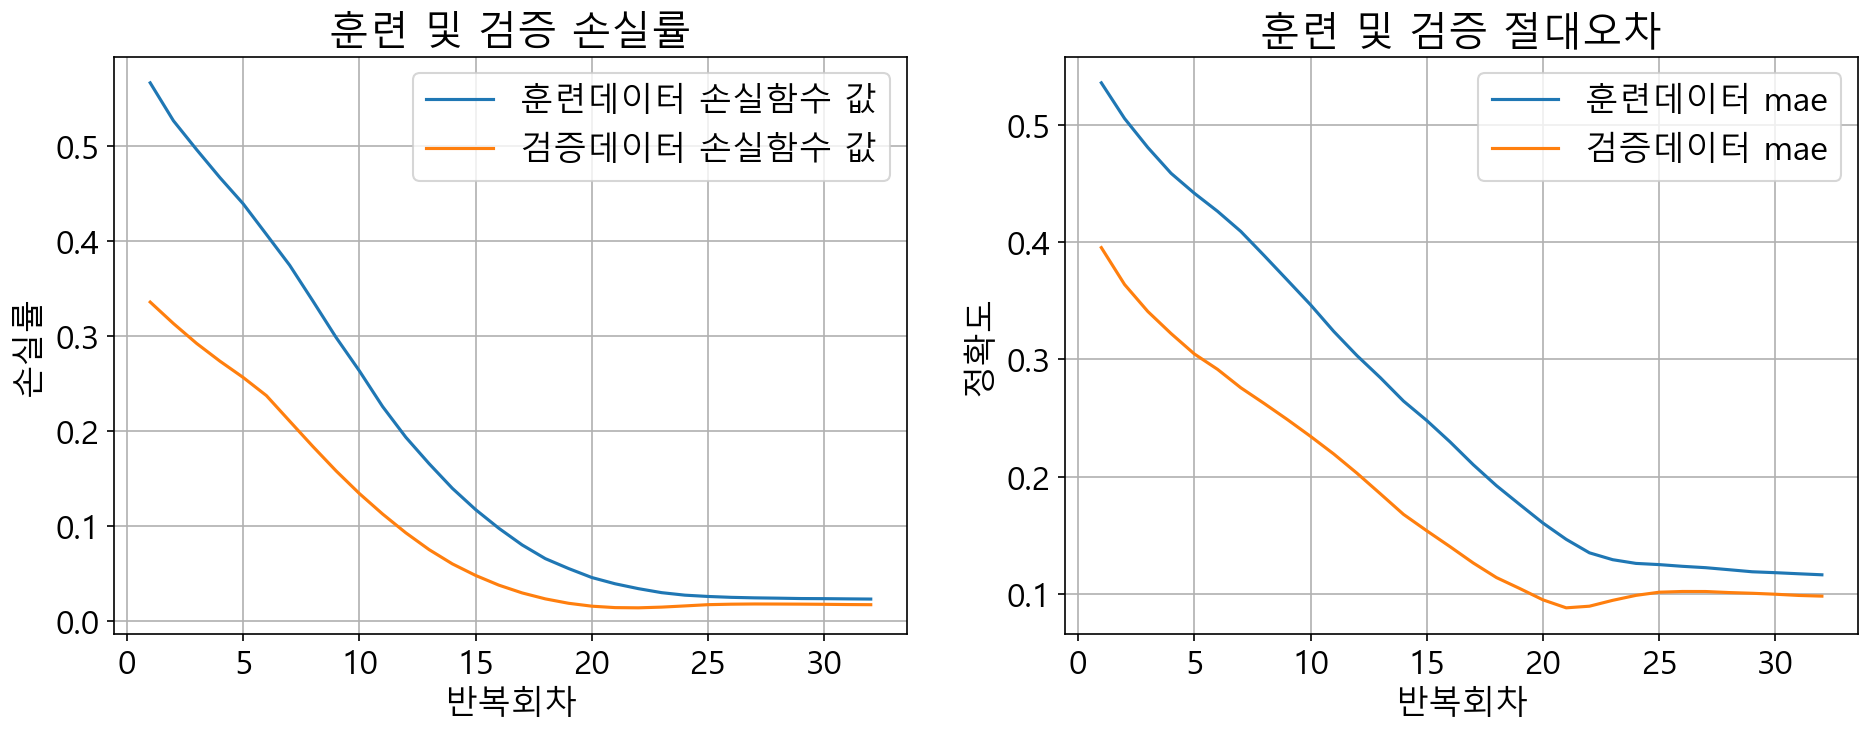

In [20]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='mae',data=result_df,label='훈련데이터 mae',ax=ax2)
sns.lineplot(x=result_df.index,y='val_mae',data=result_df,label='검증데이터 mae',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

#### 2. 모델 성능 평가

In [21]:
evaluate1 = model.evaluate(x_train,y_train)

evaluate2 = model.evaluate(x_test,y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))



1/1 [==============================] - 0s 50ms/step - loss: 0.0168 - mae: 0.0984
최종 훈련 손실률: 0.022675, 최종 훈련 절대오차: 0.116208
최종 훈련 손실률: 0.016839, 최종 훈련 절대오차: 0.098415


## #08. 학습 결과 적용
### 1. 테스트 데이터에 대한 예측 결과 산정

In [22]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 126ms/step
[[-0.6588259 ]
 [-0.65139043]
 [-0.6419085 ]
 [-0.26394656]
 [-0.15406226]
 [-0.6767796 ]
 [-0.73079133]
 [-0.9269775 ]
 [-0.195677  ]
 [ 1.6685627 ]
 [-0.6517675 ]
 [ 1.1355231 ]
 [ 1.0028389 ]
 [ 1.9885781 ]
 [-0.99331546]
 [ 1.098028  ]
 [-0.7005975 ]]


### 2. 결과 데이터 구성

In [23]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 30ms/step


In [24]:
train_df = pd.DataFrame(x_train,columns = x.columns)
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.901344,-0.905194,-0.910571,-0.902581,-0.905521,-0.901350,-0.862814,-0.853216,-0.009598
1,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,-1.092422,-1.359582,0.267161
2,-0.659101,-0.779008,-0.696689,-0.711407,-0.758186,-0.726039,-0.790823,-0.761706,-0.728004,-0.761217,-0.695469,-0.065748
3,-0.368297,-0.396891,-0.327179,-0.480910,-0.496891,-0.466210,-0.511254,-0.482346,-0.452830,-0.563830,-0.428043,-0.135787
4,1.577847,1.731046,1.207709,1.723689,1.846825,1.455565,1.946749,1.554578,1.188140,2.083485,1.781151,0.302335


In [25]:
test_df = pd.DataFrame(x_test,columns = x.columns)
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.711407,-0.693048,-0.726039,-0.676317,-0.705421,-0.728004,-0.732189,-0.658826,-0.073364
1,-0.770948,-0.761480,-0.611417,-0.793211,-0.787101,-0.729863,-0.779077,-0.726681,-0.668631,-0.746703,-0.651390,-0.095313
2,-0.580807,-0.670333,-0.634156,-0.651880,-0.688985,-0.674770,-0.716326,-0.702314,-0.684706,-0.688648,-0.641909,-0.046740
3,-0.043940,-0.204080,-0.099788,-0.193473,-0.278660,-0.227557,-0.351486,-0.305248,-0.260371,-0.383859,-0.263947,-0.119912
4,0.235678,-0.084887,0.013907,0.079999,-0.099752,-0.047479,-0.246445,-0.200537,-0.157535,-0.180666,-0.154062,-0.026603


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

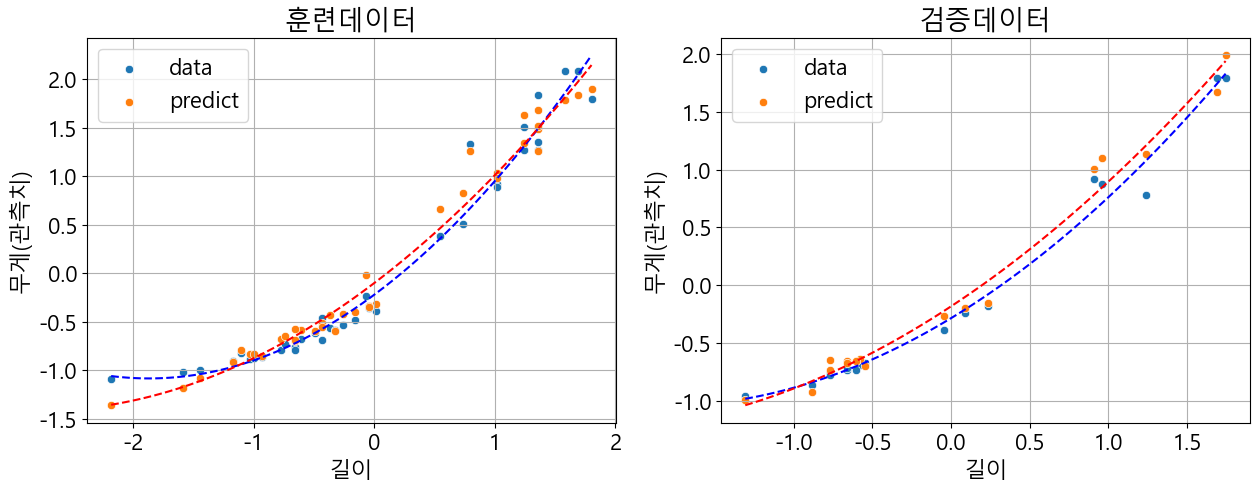

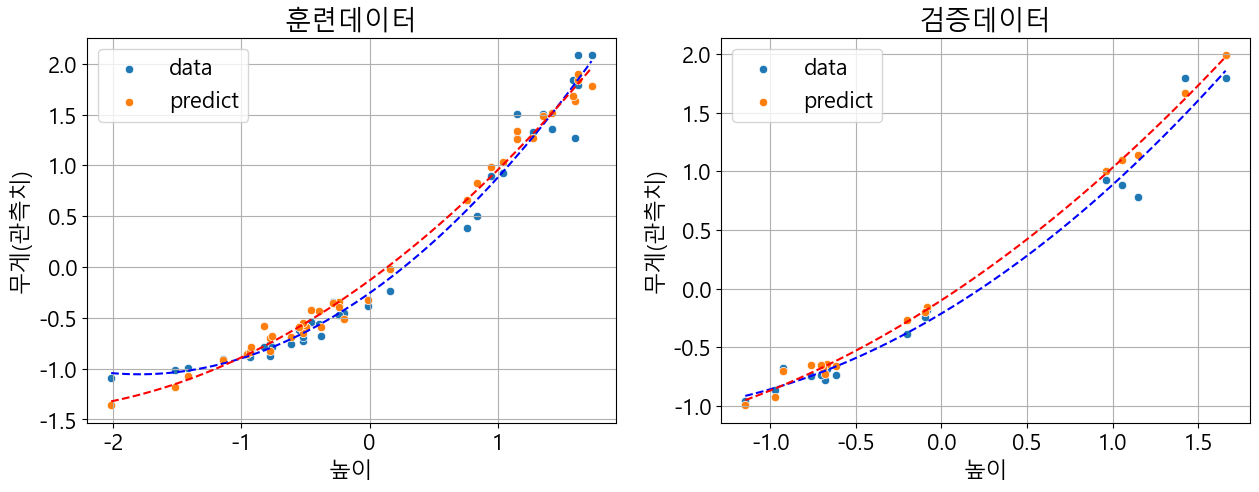

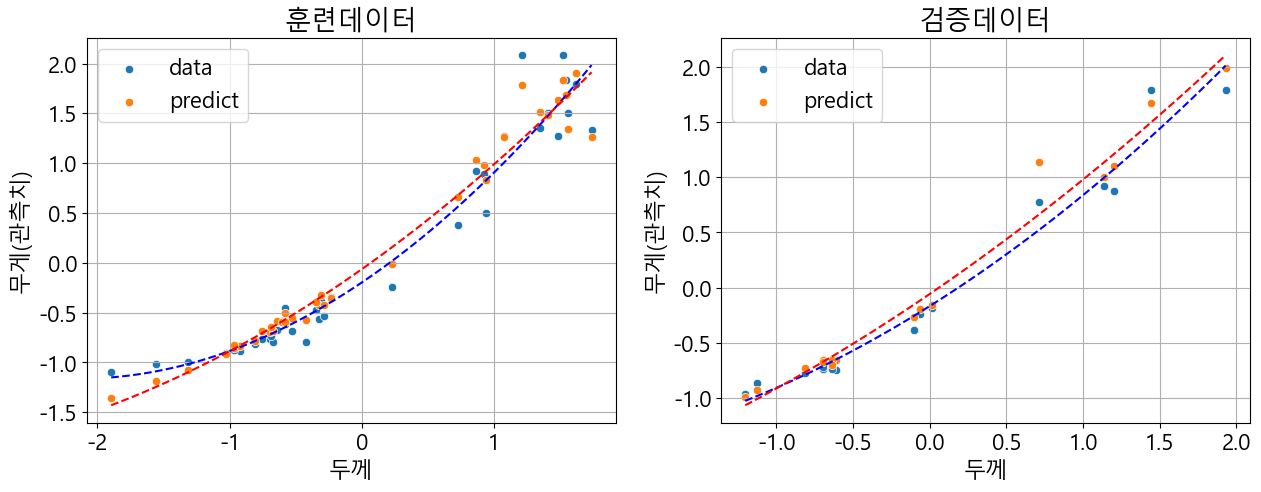

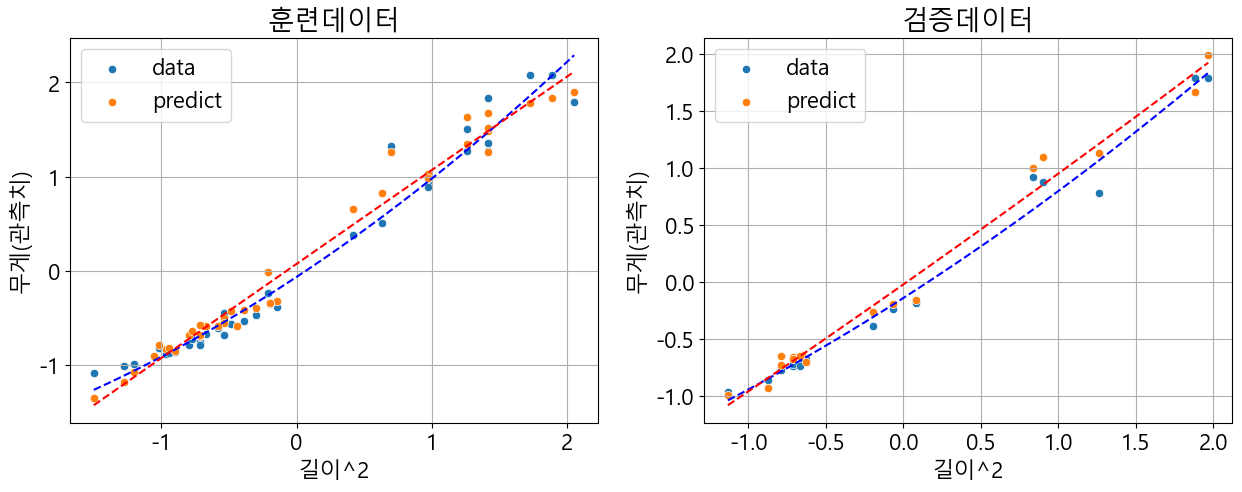

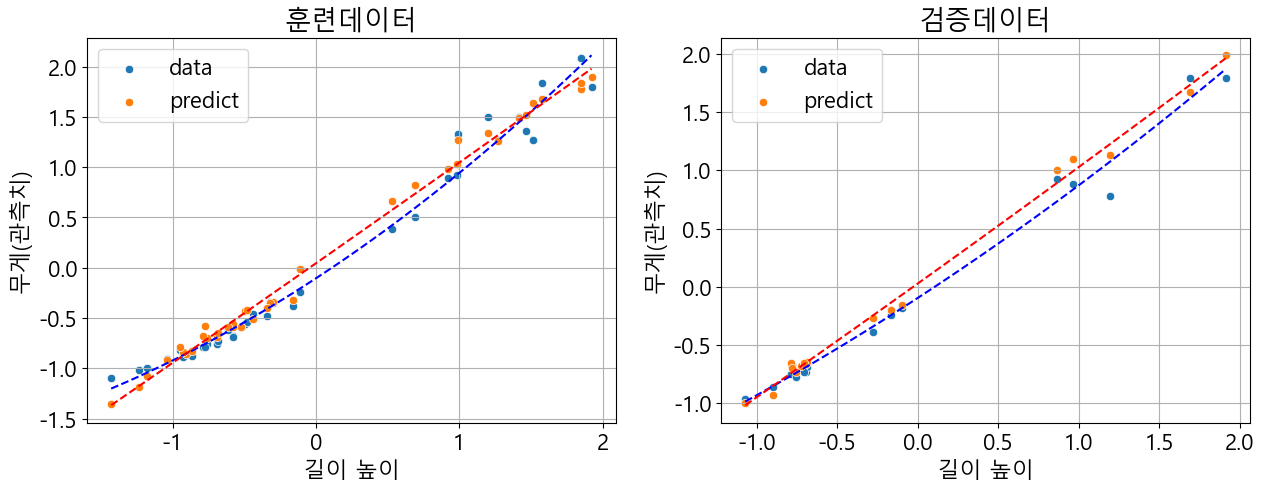

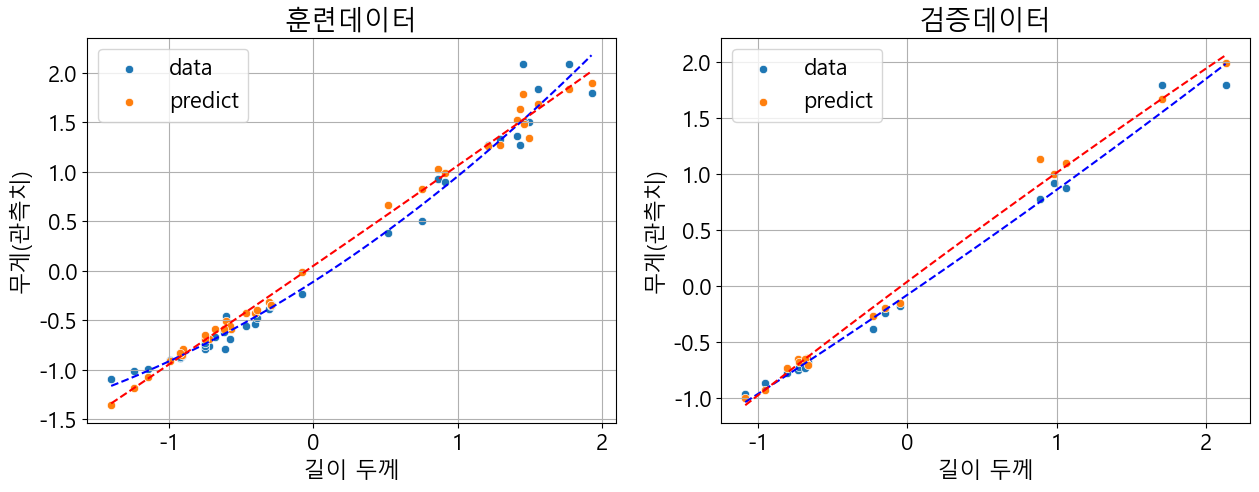

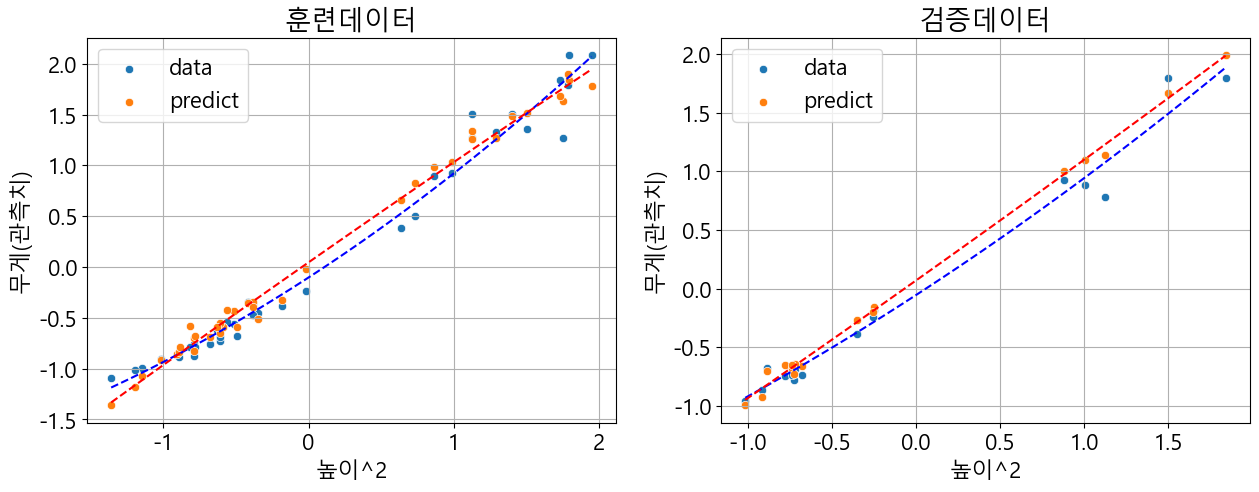

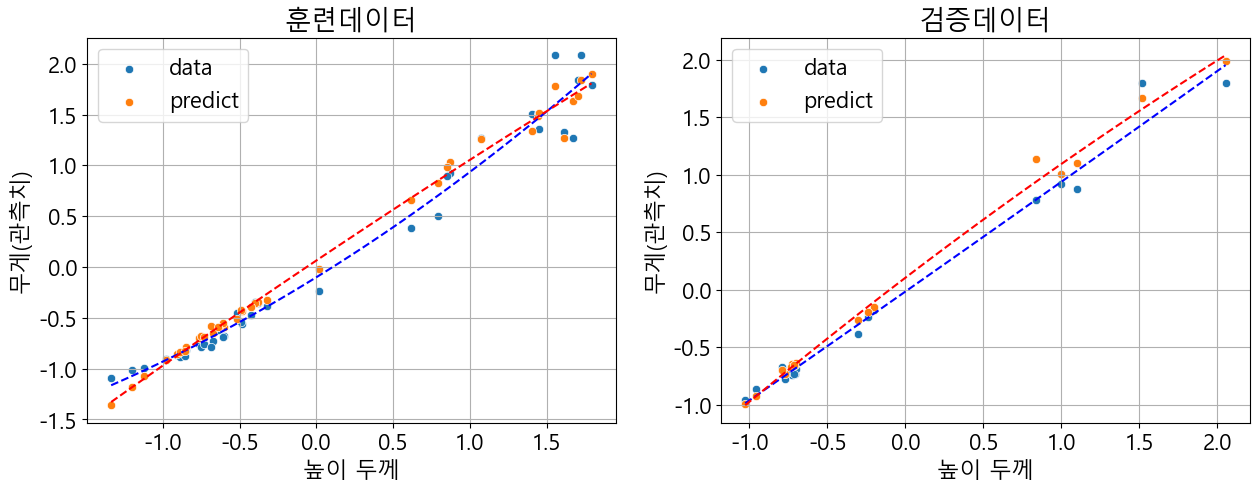

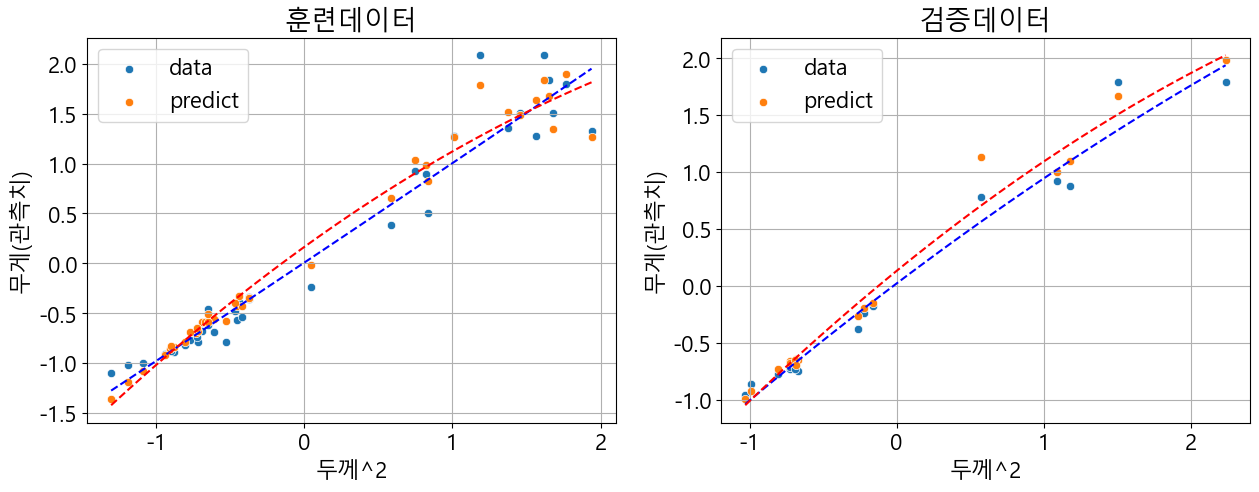

In [26]:
for key in x.columns:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))
